## Dataset

In [267]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from skimage.measure import label, regionprops

data = pd.read_csv('../Data/train.csv')

train_data1 = np.load('../Data/data0.npy')
train_lab1 = np.load('../Data/lab0.npy')

n,m,k = train_data1.shape


### Image Segmentation for Dataset

/tmp/ipykernel_4139881/3462075962.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  digits_regions = np.array(digits_regions)


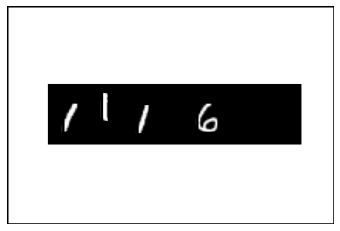

In [285]:
import numpy as np 
import pandas as pd
import cv2
import matplotlib.pyplot as plt


def threshold(img, thres):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] > thres:
                img[i][j] = 255
            else:
                img[i][j] = 0

    return img


def get_digits_regions_for_all_images(train_data):
    digits_regions = []
    for i in range(len(train_data)):
        plt.imshow(train_data[i])
        plt.axis('off')
        plt.savefig('img.png')
        img = cv2.imread('img.png')
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thresh = threshold(gray,125)
        labels = label(thresh,connectivity=thresh.ndim)
        regions = regionprops(labels)
        digregion = []
        for region in regions:
            minr, minc, maxr, maxc = region.bbox
            cv2.rectangle(img, (minc, minr), (maxc, maxr), (0, 0, 0), 2)
            digregion.append(img[minr:maxr, minc:maxc])
        digregion.pop(0)
        # print(i,len(digregion),sep=" : ")
        digits_regions.append(digregion)
        plt.axis('off')
        plt.imshow(img)

    digits_regions = np.array(digits_regions)

    return digits_regions



digits_regions = get_digits_regions_for_all_images(train_data1[0:200])
np.save('d0.npy', digits_regions, allow_pickle=True)


# save in npy file


# plt.imshow(resizedImages[2][0])



In [295]:
def padding_digits_regions(digits_regions):
    padding_digits_regions = []
    for i in range(len(digits_regions)):
        padding_digits_regions.append([])
        for j in range(len(digits_regions[i])):
            h, w = digits_regions[i][j].shape[:2]
            if h > 28 and w > 28:
                padding_digits_regions[i].append(cv2.copyMakeBorder(
                    digits_regions[i][j], 15,15,15,15, cv2.BORDER_CONSTANT, value=[0, 0, 0]))
            else:
               new_img = np.zeros((28, 28, 3), dtype=np.uint8)
               pad_h = (28 - h) // 2
               pad_w = (28 - w) // 2
               if pad_h < 0:
                   pad_h = 0
               if pad_w < 0:
                   pad_w = 0
               padding_digits_regions[i].append(cv2.copyMakeBorder(
                   digits_regions[i][j],  15, 15, 15, 15, cv2.BORDER_CONSTANT, value=[0, 0, 0]))
    padding_digits_regions = np.array(padding_digits_regions)
    return padding_digits_regions


def resizingImages(padding_digits_regions):
    size = (28, 28)
    resizedImages = []
    for i in range(len(padding_digits_regions)):
        resizedImages.append([])
        for j in range(len(padding_digits_regions[i])):            # if
            resizedImages[i].append(cv2.resize(
                padding_digits_regions[i][j], size))
    resizedImages = np.array(resizedImages)

    return resizedImages


padding_digits_region = padding_digits_regions(digits_regions)
resizedImages = resizingImages(padding_digits_region)


/tmp/ipykernel_4139881/2141384141.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  padding_digits_regions = np.array(padding_digits_regions)
/tmp/ipykernel_4139881/2141384141.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  resizedImages = np.array(resizedImages)


### Handling very near Digits

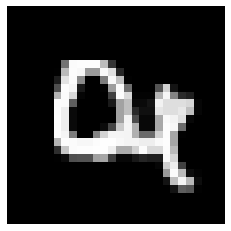

In [281]:

def handle_3_digits(resizedImages):
    for i in range(len(resizedImages)):
        if len(resizedImages[i]) == 3 or len(resizedImages[i]) == 2:
            max_size = 0
            max_index = 0
            for j in range(len(resizedImages[i])):
                if resizedImages[i][j].shape[0] > max_size:
                    max_size = resizedImages[i][j].shape[0]
                    max_index = j
            kernel = np.ones((2,2),np.uint8)
            dilation = cv2.dilate(resizedImages[i][max_index],kernel,iterations = 1)
            erosion = cv2.erode(dilation,kernel,iterations = 1)
            resizedImages[i].pop(max_index)
            plt.imshow(erosion)
            plt.axis('off')
            plt.savefig('img.png')
            img = cv2.imread('img.png')
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            thresh = threshold(gray,125)
            labels = label(thresh,connectivity=thresh.ndim)
            regions = regionprops(labels)
            digregion = []
            for region in regions:
                minr, minc, maxr, maxc = region.bbox
                cv2.rectangle(img, (minc, minr), (maxc, maxr), (0, 0, 0), 2)
                digregion.append(img[minr:maxr, minc:maxc])
            digregion.pop(0)
            for j in range(len(digregion)):
                digregion[j] = cv2.copyMakeBorder(digregion[j], 15, 15, 15, 15, cv2.BORDER_CONSTANT, value=[0, 0, 0])
            size = (28,28)
            for j in range(len(digregion)):
                digregion[j] = cv2.resize(digregion[j], size)
            for j in range(len(digregion)):
                resizedImages[i].append(digregion[j])
            
            resizedImages = np.array(resizedImages)

    return resizedImages


def handle_5_digits(resizedImages):
    for i in range(len(resizedImages)):
        # remove the image with least size
        if len(resizedImages[i]) == 5:
            min_size = 1000
            min_index = -1
            for j in range(len(resizedImages[i])):
                if resizedImages[i][j].shape[0] < min_size:
                    min_size = resizedImages[i][j].shape[0]
                    min_index = j
            if(min_index != -1):
                resizedImages[i].pop(min_index)
            resizedImages = np.array(resizedImages)
    return resizedImages

def handle_6_digits(resizedImages):
    # renmove two smallest images
    for i in range(len(resizedImages)):
        if len(resizedImages[i])==6 :
            min_size = 1000
            mini_ind1 = -1
            mini_ind2 = -1
            for j in range(len(resizedImages[i])):
                if resizedImages[i][j].shape[0] < min_size:
                    min_size = resizedImages[i][j].shape[0]
                    mini_ind1 = j

            min_size = 1000
            for j in range(len(resizedImages[i])):
                if resizedImages[i][j].shape[0] < min_size and j!=mini_ind1:
                    min_size = resizedImages[i][j].shape[0]
                    mini_ind2 = j

            if(mini_ind1 != -1 and mini_ind2 != -1):
                resizedImages[i].pop(mini_ind1)
                resizedImages[i].pop(mini_ind2)
            resizedImages = np.array(resizedImages)
    return resizedImages


# abcd = np.load('d2.npy',allow_pickle=True)


finalD = handle_3_digits(resizedImages)
finalD1 = handle_5_digits(finalD)
finalData = handle_6_digits(finalD1)

# plt.imshow(finalData[12][2])




## CNN for MNIST

In [113]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.optimizers import RMSprop


In [112]:


model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
          activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


## MNIST Dataset

In [111]:

mnist_images = keras.datasets.mnist.load_data()

(x_train, y_train), (x_test, y_test) = mnist_images

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)



11490434/11490434 [==============================] - 1s 0us/step


In [114]:
# train the model   # Compile the model
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy', metrics=['accuracy'])

# data augmentation
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1,
                             height_shift_range=0.1, zoom_range=0.1)
datagen.fit(x_train)

# Train the model
model.fit_generator(datagen.flow(x_train, y_train, batch_size=86), epochs=20)


/home/abhishek/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20


/tmp/ipykernel_4139881/3964528324.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train, y_train, batch_size=86), epochs=20)
2023-01-31 02:54:25.244363: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 14882816 exceeds 10% of free system memory.
2023-01-31 02:54:25.345578: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 26542080 exceeds 10% of free system memory.
2023-01-31 02:54:25.345775: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 14882816 exceeds 10% of free system memory.
2023-01-31 02:54:25.345834: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 26542080 exceeds 10% of free system memory.


  1/698 [..............................] - ETA: 11:13 - loss: 2.3178 - accuracy: 0.1163

2023-01-31 02:54:25.484712: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 14882816 exceeds 10% of free system memory.


698/698 [==============================] - 129s 184ms/step - loss: 0.4497 - accuracy: 0.8597
Epoch 2/20
698/698 [==============================] - 120s 172ms/step - loss: 0.2012 - accuracy: 0.9419
Epoch 3/20
698/698 [==============================] - 116s 167ms/step - loss: 0.1652 - accuracy: 0.9524
Epoch 4/20
698/698 [==============================] - 118s 170ms/step - loss: 0.1492 - accuracy: 0.9582
Epoch 5/20
698/698 [==============================] - 122s 175ms/step - loss: 0.1415 - accuracy: 0.9606
Epoch 6/20
698/698 [==============================] - 115s 165ms/step - loss: 0.1436 - accuracy: 0.9605
Epoch 7/20
698/698 [==============================] - 118s 169ms/step - loss: 0.1446 - accuracy: 0.9611
Epoch 8/20
698/698 [==============================] - 120s 172ms/step - loss: 0.1405 - accuracy: 0.9637
Epoch 9/20
698/698 [==============================] - 129s 184ms/step - loss: 0.1457 - accuracy: 0.9615
Epoch 10/20
698/698 [==============================] - 124s 178ms/step - lo

### Evaluaiton of CNN Model for MNIST

In [116]:
# evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.0931665226817131
Test accuracy: 0.9847000241279602


In [158]:
model.save('modelMNIST.h5')

### For saving the model and using it for calculations

In [218]:
# merge two npy files
array1 = np.load('d2.npy',allow_pickle=True)
array2 = np.load('d0.npy',allow_pickle=True)
merged_array = np.concatenate((array1, array2), axis=0)
np.save('merged_array.npy', merged_array)


In [296]:
from keras.models import load_model
model = load_model('modelMNIST.h5')

y_train = train_lab1[:200]
accuracy = 0



for i in range(len(resizedImages)):
    sum = 0
    for j in range(len(resizedImages[i])):
        img = resizedImages[i][j]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.reshape(1, 28, 28, 1)
        img = img.astype('float32')
        img /= 255
        pred = model.predict(img)
        sum = sum + np.argmax(pred)
    if sum == y_train[i]:
        accuracy += 1
    print(sum, y_train[i])

print("Accuracy: ", accuracy/len(resizedImages))

1/1 [==============================] - 0s 25ms/step
25 25
1/1 [==============================] - 0s 22ms/step
18 18
1/1 [==============================] - 0s 25ms/step
21 21
1/1 [==============================] - 0s 24ms/step
25 25
1/1 [==============================] - 0s 21ms/step
16 23
1/1 [==============================] - 0s 26ms/step
16 16
1/1 [==============================] - 0s 25ms/step
10 12
1/1 [==============================] - 0s 22ms/step
11 14
1/1 [==============================] - 0s 26ms/step
14 14
1/1 [==============================] - 0s 23ms/step
20 20
1/1 [==============================] - 0s 21ms/step
14 14
1/1 [==============================] - 0s 22ms/step
13 11
1/1 [==============================] - 0s 20ms/step
9 15
1/1 [==============================] - 0s 20ms/step
10 18
1/1 [==============================] - 0s 21ms/step
27 26
1/1 [==============================] - 0s 22ms/step
3 6
1/1 [==============================] - 0s 19ms/step
20 20
1/1 [============